# Gaussian Process Recurrent Neural Networks
- Here is the demo for visualizing the latent dynamics recovered from (1). PLDS, (2). PGPLVM and (3). GP-RNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import tensorflow as tf
from edward.models import Normal, MultivariateNormalTriL, Poisson, Empirical, PointMass
from edward.util import get_session, get_variables
from scipy.stats import poisson
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys   
sys.setrecursionlimit(10000)
from tensorflow.contrib import slim
import funs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1234)

/home/sheqi/.conda/envs/tensorflow1_5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Hyperparameters

In [2]:
H  = 15   # number of hidden units 
          # (Gaussian larger may be worse, and select: 15, #for possion larger is better 25 > 20 > 15)
          # smaller time points, larger H lead to worse results
L  = 3    # number of latents
D  = 50   # number of features
N  = 200  # number of time points
dt = 0.01 # temporal precision (smaller means slower change)

# Generating true dynamics and observations

In [3]:
# true dynamics
z_true = np.zeros((N, 3))
z_all = funs.dyn_lorenz(4 * N, dt)

z_sim = z_all[-N:,:]
z_sim_norm = z_sim - z_sim.mean(axis=0)
z_sim_norm /= np.linalg.norm(z_sim_norm, axis=0, ord=np.inf)

z_true = z_sim_norm

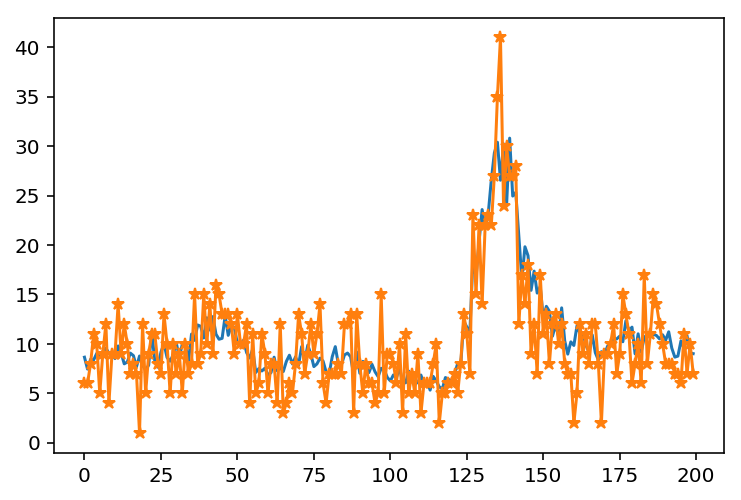

In [4]:
# latent states mapping to observatios
x_train0 = funs.map_sine(z_true, L, D)
x_train0 = x_train0.astype(np.float32)
plt.figure()

Amp = 10
plt.plot(Amp*np.exp(x_train0[:,2]));
x_train = np.zeros([N, D])
x_train = poisson.rvs(mu=Amp*np.exp(x_train0), size=[N, D])
plt.plot(x_train[:,2], marker='*')
x_train = x_train.astype('float32')

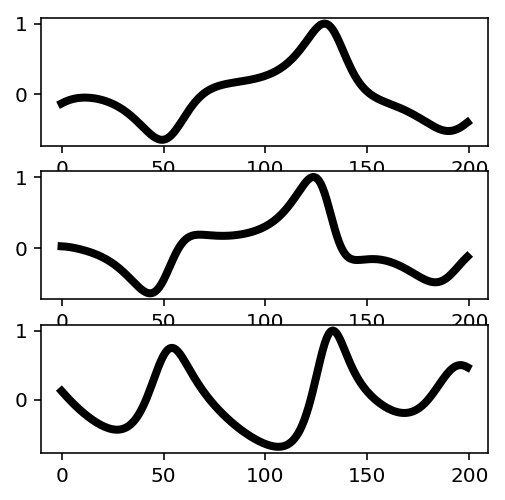

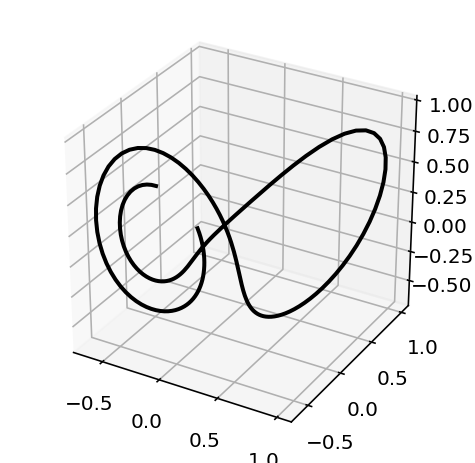

In [5]:
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(z_true[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(z_true[:, 1], lw=4, color='k')

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(z_true[:, 2], lw=4, color='k')

plt.figure(figsize=(4, 4))
ax = plt.gca(projection='3d')
ax.plot(*z_true.T, lw = 2, color='k')

## Model-Part1:  dynamics

In [6]:
# Model
zt = Normal(loc=tf.zeros(L), scale=tf.ones(L))
ht = tf.constant(0, dtype=tf.float32, shape=[H])
ct = tf.constant(0, dtype=tf.float32, shape=[H])

c = [] 
h = []
z = []
mu = []
sig = []

reuse = None

for t in range(0, N):
    if t > 0:
        reuse = True
    #ht = funs.normal_cell(ht, zt, H)
    #ht = funs.ar1_cell(ht, zt, name='ar1', reuse=reuse)
    #ht = rnn_cell(ht, zt, name="rnn", reuse=reuse)
    ht, ct = funs.lstm_cell(zt, ht, ct, name="lstm", reuse=reuse)
    h.append(ht)
    c.append(ct)
    zt = funs.encode_z(ht, L, name="encode_z", reuse=reuse)
    #zt = funs.encode_z_ar1(ht, L)
    z.append(zt)

## Model-Part2: mapping

## Gaussian process mapping

In [7]:
# GP mapping
# z_1   = tf.stack(z,1)
# z_all = tf.transpose(z_1, [1,0])

# # kernel configuration (rbf)
# l   = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))    # length scale
# rho = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))    # marginal variance
# nsevar  = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))# noise variance
# njitter = tf.constant(1e-6, dtype=tf.float32, shape=[N])  # jitter

# #kernel = funs.kernel_fun(z_all, lengthscale=l, variance=rho, name='rbf') + tf.eye(N)*nsevar
# kernel = funs.kernel_fun(z_all, lengthscale=l, variance=rho, name='rbf') + tf.eye(N)*nsevar
# x = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(kernel))

## Gaussian process with Poisson spiking

In [8]:
# direct mapping + Poisson spiking
# z_1   = tf.stack(z,1)
# z_all = tf.transpose(z_1, [1,0])

# Wz_true = tf.Variable(tf.random_normal([L, D]))
# mu = tf.matmul(z_all, Wz_true)
# f  = tf.transpose(tf.nn.tanh(mu))
# weights = tf.Variable(1, dtype=tf.float32)

# # poisson spiking
# x = Poisson(rate=weights*tf.exp(f))

## Inducing point

In [9]:
# inducing point
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# sig_f = tf.Variable(np.log(1), dtype=tf.float32)
# l = tf.Variable(np.log(1), dtype=tf.float32)
# # sig_n = tf.Variable(np.log(0.01), dtype=tf.float32)
# # sig_f = const(np.log(1))
# # l = const(np.log(0.5))
# sig_n = const(np.log(1))
# sig_n_u = const(np.log(0.01))
# prior_sig_n = const(np.log(1))

# from edward.util import rbf

# M = 50
# u = tf.Variable(tf.random_normal([K,M])*1e-2, dtype=tf.float32)

# z = Normal(loc=tf.zeros([K, N]), scale=tf.ones([K, N])*tf.exp(prior_sig_n))
# Kernel_uu = rbf(tf.transpose(u),lengthscale=tf.exp(l),
#                 variance=tf.exp(sig_f))+tf.exp(sig_n_u)*tf.eye(M)
# Kernel_zu = rbf(tf.transpose(z),tf.transpose(u),
#                 lengthscale=tf.exp(l),variance=tf.exp(sig_f))
# Kernel = tf.matmul(Kernel_zu,tf.matmul(tf.matrix_inverse(Kernel_uu),
#                                        tf.transpose(Kernel_zu)))+tf.exp(sig_n)*tf.eye(N)
# x = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(Kernel))

In [10]:
# GP mapping + Poisson spiking
z_1   = tf.stack(z,1)
z_all = tf.transpose(z_1, [1,0])

with tf.name_scope("GP_hyper"):
    # kernel configuration (rbf)
    l   = tf.nn.softplus(tf.Variable(5, dtype=tf.float32))    # length scale
    #l = tf.nn.softplus(Normal(loc=tf.zeros(1), scale=tf.nn.softplus(tf.ones(1))))
    rho = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))    # marginal variance
    #rho = tf.nn.softplus(Normal(loc=tf.zeros(1), scale=tf.nn.softplus(tf.ones(1))))

    nsevar  = tf.nn.softplus(tf.Variable(2, dtype=tf.float32))# noise variance
    njitter = tf.constant(1e-4, dtype=tf.float32, shape=[N])  # jitter
    bias = tf.Variable(0, dtype=tf.float32)
    weights = tf.Variable(1, dtype=tf.float32)

kernel = funs.kernel_fun(z_all, lengthscale=l, variance=rho, name='rbf') + tf.diag(njitter)
f = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(kernel))

# poisson spiking
x = Poisson(rate=Amp*tf.exp(f))

# Variational Inference

In [11]:
# Mean field Variational Inference
# MAP for "f" and MAP for "z"

qz = []

with tf.name_scope("posterior_lat_state"):
    for t in range(0, N):
        #qz0 = Empirical(params=tf.Variable(tf.zeros([100,L])))
        #qz0 = Normal(loc=tf.Variable(tf.zeros(L)), scale=tf.nn.softplus(tf.Variable(tf.ones(L))))
        #qz.append(qz0)
        qz0 = PointMass(params=tf.Variable(tf.zeros(L)))
        qz.append(qz0)

with tf.name_scope("posterior_fun_value"):
    qf = PointMass(params=tf.Variable(tf.zeros([D, N])))
#qf = Normal(loc=tf.Variable(tf.random_normal([D, N])), scale = tf.nn.softplus(tf.Variable(tf.random_normal([D, N]))))

with tf.name_scope("posterior_GP_hyper"):
    ql   = Normal(loc=tf.Variable(tf.zeros(1)), scale=tf.nn.softplus(tf.ones(1)))    # length scale
    qrho = Normal(loc=tf.Variable(tf.zeros(1)), scale=tf.nn.softplus(tf.ones(1)))    # marginal variance

In [12]:
# pairlist = {z_all: z_true}
z_pair = dict(zip(z, qz))
f_pair = {f: qf}
data_pair = {x: x_train.T}
lrho_pair = {l: ql, rho: qrho}

iteration = 500

inference_1 = ed.MAP(f_pair, {**data_pair, **z_pair})
#optimizer_1 = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
#inference_1.initialize(optimizer=optimizer_1, n_print=100, n_samples=1)
inference_1.initialize()


inference_2 = ed.MAP(z_pair, {**data_pair, **f_pair})
#optimizer_2 = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
#inference_2.initialize(optimizer=optimizer_2, n_print=100, n_samples=1)
inference_2.initialize()

#inference_3 = ed.KLqp(lrho_pair, {**f_pair, **data_pair, **z_pair})
#optimizer_3 = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
#inference_3.initialize(optimizer=optimizer_3, n_print=100, n_samples=1)

tf.global_variables_initializer().run()

loss_1 = np.empty(iteration, dtype=np.float32)
loss_2 = np.empty(iteration, dtype=np.float32)

for i0 in range(iteration):
#     info_dict_1 = inference_1.update()
#     info_dict_1 = inference_1.update()
#     info_dict_1 = inference_1.update()
#     info_dict_2 = inference_2.update()
#     info_dict_2 = inference_2.update()
#     info_dict_2 = inference_2.update()
    for _ in range(3):
        info_dict_1 = inference_1.update()
    for _ in range(3):
        info_dict_2 = inference_2.update()
    
    loss_1[i0] = info_dict_1["loss"]
    loss_2[i0] = info_dict_2["loss"]
    
    inference_1.print_progress(info_dict_1)
    #inference_2.print_progress(info_dict_2)
    
#inference.run(n_iter=1000, n_print=100, n_samples=10, logdir='log/rnn_gplvm')

/home/sheqi/.conda/envs/tensorflow1_5/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1020/1000 [102%] ██████████████████████████████ Elapsed: 1128s | Loss: -5367.074
1050/1000 [105%] ███████████████████████████████ Elapsed: 1151s | Loss: -5644.952
1080/1000 [108%] ████████████████████████████████ Elapsed: 1176s | Loss: -6074.896
1110/1000 [111%] █████████████████████████████████ Elapsed: 1200s | Loss: -6531.117
1140/1000 [113%] ██████████████████████████████████ Elapsed: 1225s | Loss: -6742.936
1170/1000 [117%] ███████████████████████████████████ Elapsed: 1249s | Loss: -6848.772
1200/1000 [120%] ████████████████████████████████████ Elapsed: 1274s | Loss: -6877.424
1230/1000 [123%] ████████████████████████████████████ Elapsed: 1300s | Loss: -6933.982
1260/1000 [126%] █████████████████████████████████████ Elapsed: 1324s | Loss: -6934.077
1290/1000 [129%] ██████████████████████████████████████ Elapsed: 1348s | Loss: -7077.941
1320/1000 [132%] ███████████████████████████████████████ Elapsed: 1371s | Loss: -7202.289
1350/1000 [135%] ████████████████████████████████████████ 

Text(0.5, 0, 'Iteration')

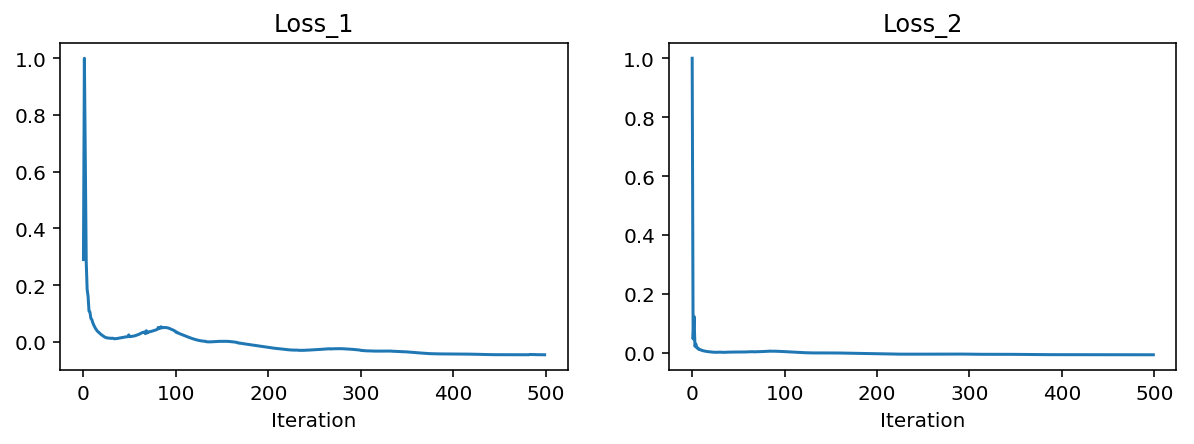

In [13]:
# see the two loss
f0, axs = plt.subplots(1,2,figsize=(10,3))

axs[0].plot(loss_1 / loss_1.max())
axs[0].set_title("Loss_1")
axs[0].set_xlabel("Iteration")

axs[1].plot(loss_2 / loss_2.max())
axs[1].set_title("Loss_2")
axs[1].set_xlabel("Iteration")

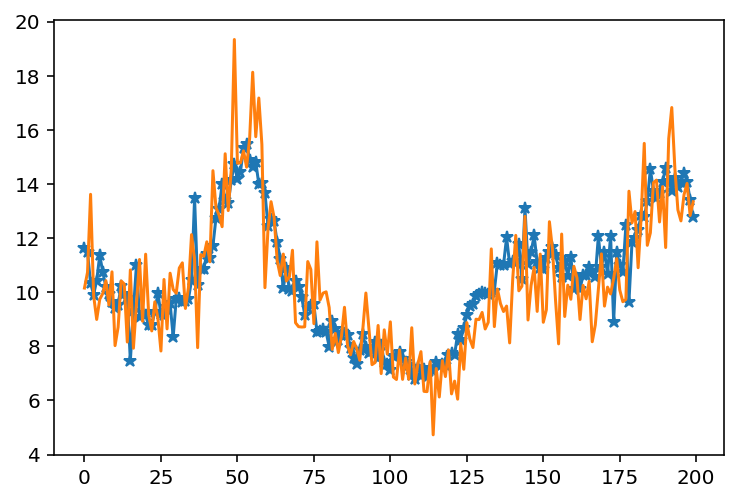

In [14]:
sess = ed.get_session()

x_train_post = ed.copy(x, {**f_pair, **z_pair})

x_train_mean_est = np.mean([sess.run(x_train_post) for _ in range(iteration)], axis=0)

n_dim = 3
plt.plot(x_train_mean_est[n_dim,:], marker='*')
plt.plot(Amp*np.exp(x_train0)[:,n_dim])

# Dynamics recovery performance 

In [15]:
sess = ed.get_session()

qz_mean = []
qz_var = []

for qz_i in qz:
    qz_mean.append(qz_i.mean())
    qz_var.append(qz_i.variance())

qf_mean_est = sess.run(qf.mean(), feed_dict={x: x_train.T})

from scipy import signal

for n_dim in range(D): 
    qf_mean_est[n_dim,:] = signal.savgol_filter(qf_mean_est[n_dim,:], 51, 5)    
    
qz_mean_est = sess.run(qz_mean, feed_dict={f: qf_mean_est})

In [16]:
# hyperparameters: GP mapping
l_est,rho_est,nsevar_est = sess.run([l,rho,nsevar],feed_dict={x: x_train.T})
bias_est = sess.run(bias, feed_dict={x: x_train.T})
weights_est = sess.run(weights, feed_dict={x: x_train.T})

print(l_est)
print(rho_est)
print(nsevar_est)
print(bias_est)
print(weights_est)

20.882515
4.9325676
2.126928
0.0
1.0


In [17]:
weights_est = sess.run(weights, feed_dict={x: x_train.T})
print(weights_est)

1.0


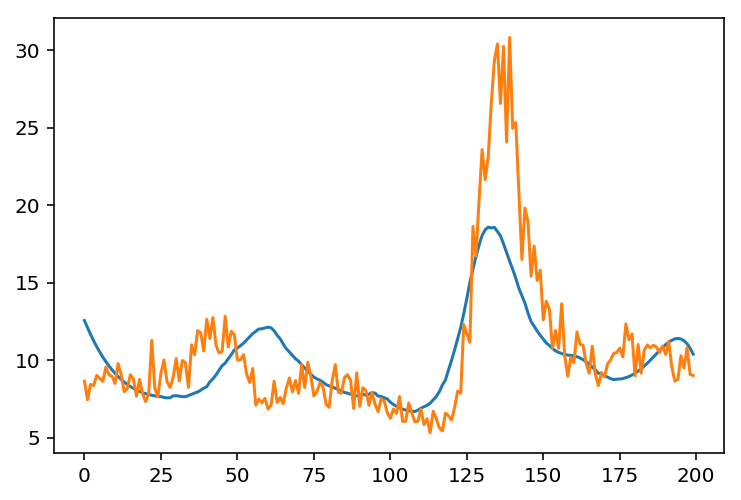

In [18]:
# learning for gp mapping
qf_mean_est = sess.run(qf.mean(),feed_dict={x: x_train.T})

from scipy import signal
n_dim = 2
qf_mean_est[n_dim,:] = signal.savgol_filter(qf_mean_est[n_dim,:], 51, 5)
plt.plot(Amp*np.exp(qf_mean_est[n_dim,:]))
plt.plot(Amp*np.exp(x_train0[:,n_dim]))

# 3D visualization

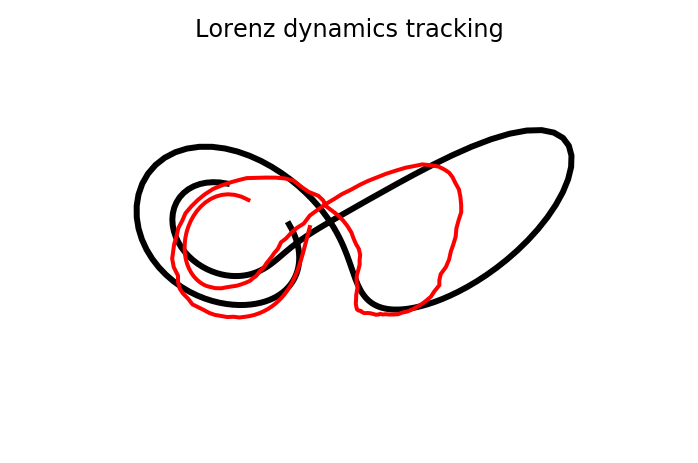

In [19]:
# match and normalization
qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
z_true_c = z_true - z_true.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1], 51, 5)
qz_est_norm_R[:,2] = signal.savgol_filter(qz_est_norm_R[:,2], 51, 5)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(z_true_norm[:,0], z_true_norm[:,1], z_true_norm[:,2], lw=3, color = 'k')
ax.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], qz_est_norm_R[:,2], lw=2, color = 'r')

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz dynamics tracking")
ax.set_axis_off()

# Each dimension comparison

Text(0.5, 1.0, '3rd dimension')

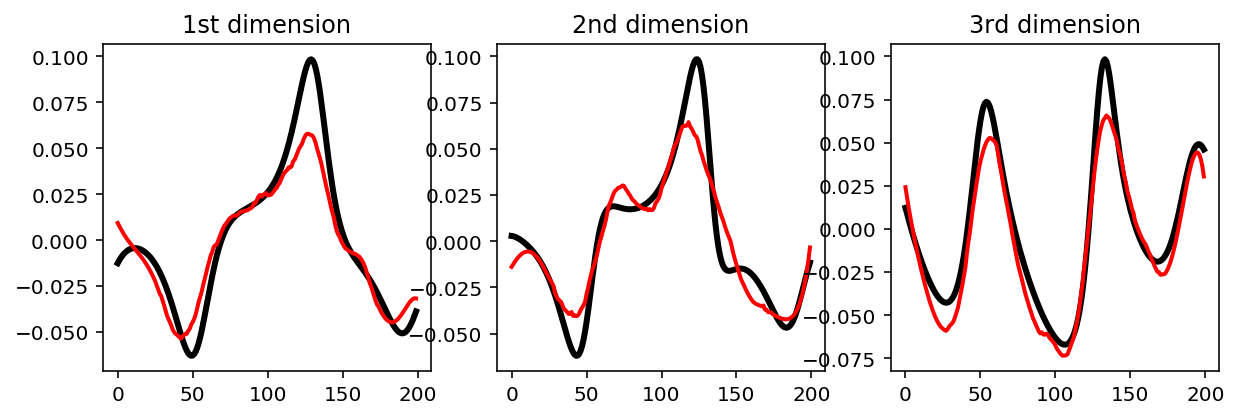

In [20]:
# each dimension matching
f0, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(z_true_norm[:,0], lw=3, color='k');
axs[0].plot(qz_est_norm_R[:,0], lw=2, color='r');
axs[0].set_title('1st dimension')
#axs[0].set_axis_off()

axs[1].plot(z_true_norm[:,1], lw=3, color='k');
axs[1].plot(qz_est_norm_R[:,1], lw=2, color='r');
axs[1].set_title('2nd dimension')
#axs[1].set_axis_off()

axs[2].plot(z_true_norm[:,2], lw=3, color='k');
axs[2].plot(qz_est_norm_R[:,2], lw=2, color='r');
axs[2].set_title('3rd dimension')
#axs[2].set_axis_off()

In [21]:
# Root mean square error
rmse = np.sqrt(((z_true_norm - qz_est_norm_R) ** 2).mean(axis=None))
print(rmse)

# R^2 fitted
from sklearn.metrics import r2_score
print(r2_score(z_true_norm[:,0], qz_est_norm_R[:,0]))
print(r2_score(z_true_norm[:,1], qz_est_norm_R[:,1])) 
print(r2_score(z_true_norm[:,2], qz_est_norm_R[:,2])) 

0.013383349127649161
0.8743296609205631
0.8782076512005674
0.9205986459623431


In [22]:
# save data for other models
np.save('spikes.npy', x_train)
from scipy import io

mat = np.load('spikes.npy')
io.savemat('spikes.mat', {'spikes': mat})

# State-of-the-arts comparison

## PLDS

0.4353050218144172
0.3640755420049304
0.7545536260158185


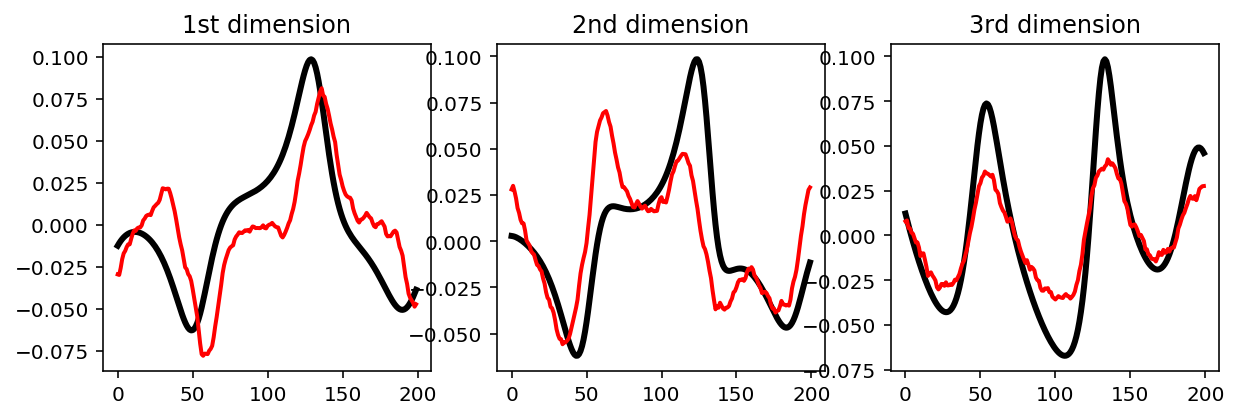

In [23]:
# Load from .mat file and compared with PLDS results
# change the file name to compare with
# PLDS, GCLDS (lars's code); AR1-NN is PfLDS; AR1-GPLVM is P-GPLVM; 
# 'PLDS_latent.mat'
# 'GCLDS_latent.mat'

PLDS = io.loadmat('PLDS_latent.mat')
PLDS_latent = PLDS['PLDS_latent']

R1 = funs.compute_optimal_rotation(np.transpose(PLDS_latent), z_true_norm, scale=True)
PLDS_latent_R = np.transpose(PLDS_latent).dot(R1)

# each dimension matching
f0, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(z_true_norm[:,0], lw=3, color='k');
axs[0].plot(PLDS_latent_R[:,0], lw=2, color='r');
axs[0].set_title('1st dimension')
#axs[0].set_axis_off()

axs[1].plot(z_true_norm[:,1], lw=3, color='k');
axs[1].plot(PLDS_latent_R[:,1], lw=2, color='r');
axs[1].set_title('2nd dimension')
#axs[1].set_axis_off()

axs[2].plot(z_true_norm[:,2], lw=3, color='k');
axs[2].plot(PLDS_latent_R[:,2], lw=2, color='r');
axs[2].set_title('3rd dimension')
#axs[2].set_axis_off()


# R^2 fitted
from sklearn.metrics import r2_score
print(r2_score(z_true_norm[:,0], PLDS_latent_R[:,0]))
print(r2_score(z_true_norm[:,1], PLDS_latent_R[:,1])) 
print(r2_score(z_true_norm[:,2], PLDS_latent_R[:,2])) 

## PGPLVM

0.6400204429653527
0.5467441032991749
0.9025602036185248


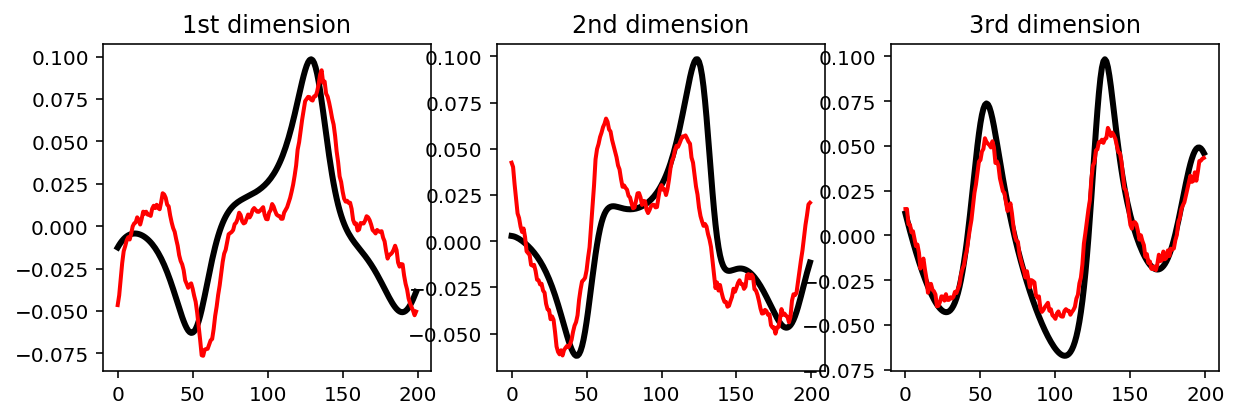

In [24]:
GCLDS = io.loadmat('PGPLVM_latent.mat')
GCLDS_latent = GCLDS['PGPLVM_latent']

R2 = funs.compute_optimal_rotation(np.transpose(GCLDS_latent), z_true_norm, scale=True)
GCLDS_latent_R = np.transpose(GCLDS_latent).dot(R2)

# each dimension matching
f0, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(z_true_norm[:,0], lw=3, color='k');
axs[0].plot(GCLDS_latent_R[:,0], lw=2, color='r');
axs[0].set_title('1st dimension')
#axs[0].set_axis_off()

axs[1].plot(z_true_norm[:,1], lw=3, color='k');
axs[1].plot(GCLDS_latent_R[:,1], lw=2, color='r');
axs[1].set_title('2nd dimension')
#axs[1].set_axis_off()

axs[2].plot(z_true_norm[:,2], lw=3, color='k');
axs[2].plot(GCLDS_latent_R[:,2], lw=2, color='r');
axs[2].set_title('3rd dimension')
#axs[2].set_axis_off()

# R^2 fitted
from sklearn.metrics import r2_score
print(r2_score(z_true_norm[:,0], GCLDS_latent_R[:,0]))
print(r2_score(z_true_norm[:,1], GCLDS_latent_R[:,1])) 
print(r2_score(z_true_norm[:,2], GCLDS_latent_R[:,2])) 

## GP-RNN

0.8333037793218101
0.7196716441760116
0.9600780155114846


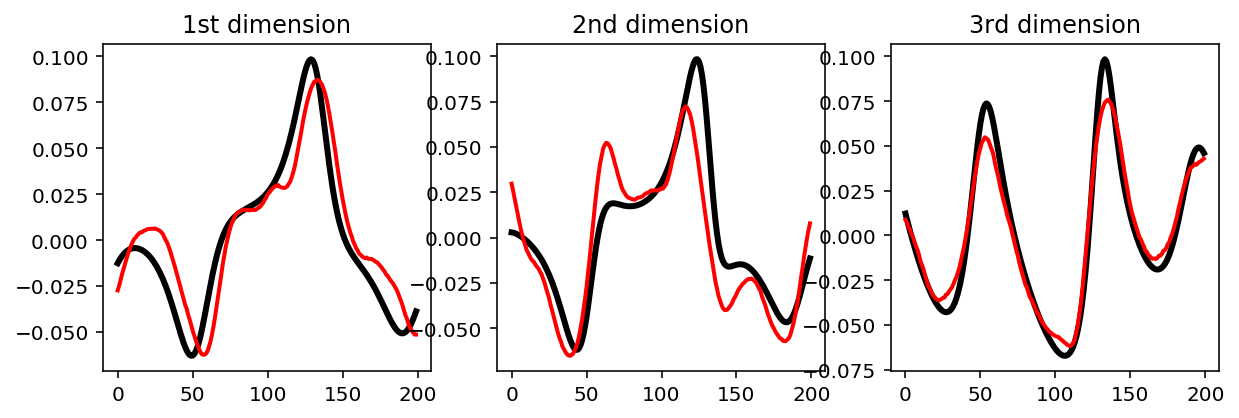

In [25]:
GP_RNN = io.loadmat('GP-RNN_latent.mat')
GP_RNN_latent = GP_RNN['GPRNN_latent']

R3 = funs.compute_optimal_rotation(np.transpose(GP_RNN_latent), z_true_norm, scale=True)
GP_RNN_latent_R = np.transpose(GP_RNN_latent).dot(R3)

# each dimension matching
f0, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(z_true_norm[:,0], lw=3, color='k');
axs[0].plot(GP_RNN_latent_R[:,0], lw=2, color='r');
axs[0].set_title('1st dimension')
#axs[0].set_axis_off()

axs[1].plot(z_true_norm[:,1], lw=3, color='k');
axs[1].plot(GP_RNN_latent_R[:,1], lw=2, color='r');
axs[1].set_title('2nd dimension')
#axs[1].set_axis_off()

axs[2].plot(z_true_norm[:,2], lw=3, color='k');
axs[2].plot(GP_RNN_latent_R[:,2], lw=2, color='r');
axs[2].set_title('3rd dimension')
#axs[2].set_axis_off()

# R^2 fitted
from sklearn.metrics import r2_score
print(r2_score(z_true_norm[:,0], GP_RNN_latent_R[:,0]))
print(r2_score(z_true_norm[:,1], GP_RNN_latent_R[:,1])) 
print(r2_score(z_true_norm[:,2], GP_RNN_latent_R[:,2])) 

# Criticism 

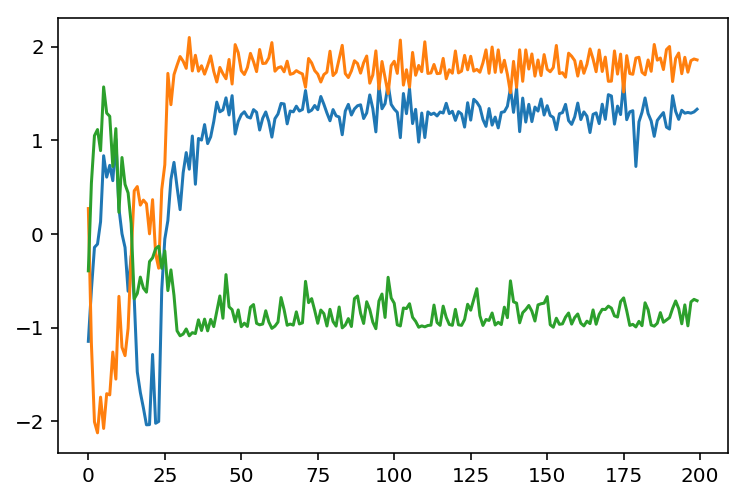

In [26]:
# test LSTM dynamics
# prior over latent states
pz_mean = []
pz_var = []

for pz_i in z:
    pz_mean.append(pz_i.mean())
    pz_var.append(pz_i.variance())
    
pz_mean_est = sess.run(pz_mean, feed_dict={x: x_train.T})
pz_var_est = sess.run(pz_var, feed_dict={x: x_train.T})

pz_all_est = np.asarray(pz_mean_est)
plt.plot(pz_all_est);

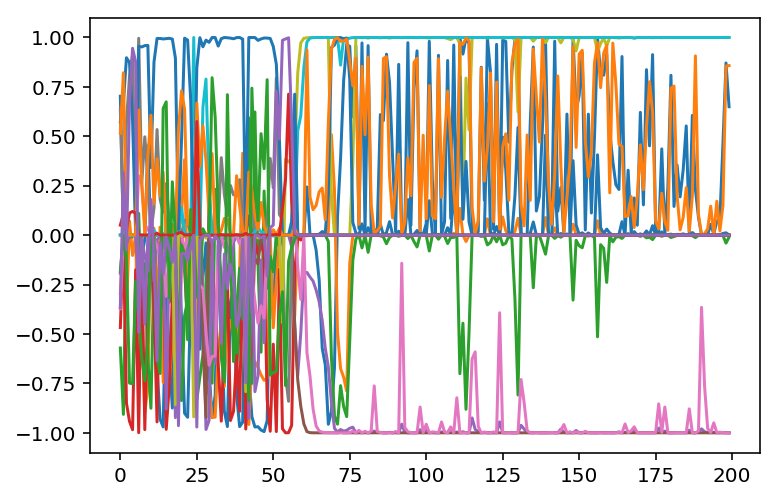

In [27]:
# hidden state
h_all_est = sess.run(h, feed_dict={x: x_train.T})
h_all_est = np.asarray(h_all_est)
plt.plot(h_all_est);

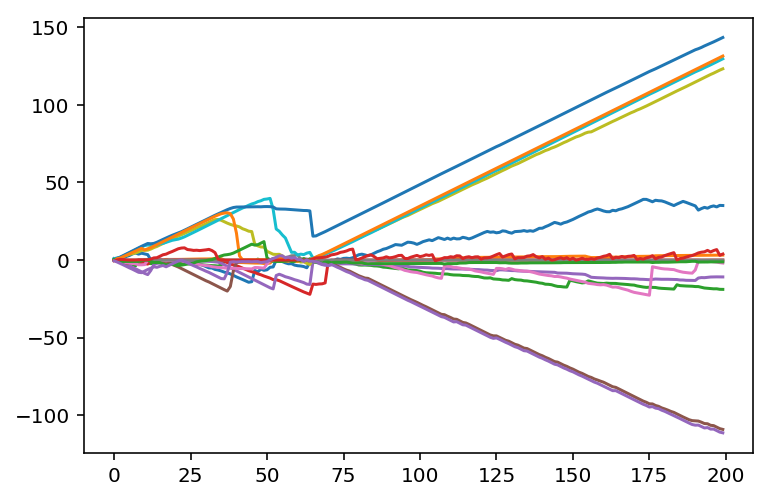

In [28]:
# cell state (only for LSTM cell)
c_all_est = sess.run(c, feed_dict={x: x_train.T})
c_all_est = np.asarray(c_all_est)
plt.plot(c_all_est);

In [29]:
# to see current trainable variables
# tf.trainable_variables()
#sess.run(tf.trainable_variables('encode_z/bmean:0'))
# tf.global_variables()
# initializers = [var.initializer for var in tf.trainable_variables() if 'posterior_lat_state' in var.name]
# print(initializers)

In [30]:
# fix_vars_1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "lstm")
# fix_vars_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encode_z")
# fix_vars_3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "GP_hyper")

# fix_vars_1_trained = sess.run(fix_vars_1)
# fix_vars_2_trained = sess.run(fix_vars_2)
# fix_vars_3_trained = sess.run(fix_vars_3)

# aa = dict(zip(fix_vars_1, fix_vars_1_trained))

In [31]:
# # Testing for our new data: keep global parameters fixed and infer local variable again
# # http://edwardlib.org/tutorials/criticism
# # 1. create local posterior factors for test data, assuming test data
# # has N_test many data points
# qz_test = []

# with tf.name_scope("posterior_latent_state_test"):
#     for t in range(0, N):
#         qz0_test = PointMass(params=tf.Variable(tf.zeros(L)))
#         qz_test.append(qz0_test)

# with tf.name_scope("posterior_fun_value_test"):
#     qf_test = PointMass(params=tf.Variable(tf.zeros([D, N])))

# z_pair_test = dict(zip(z, qz_test))
# f_pair_test = {f: qf_test}
# data_pair_test = {x: x_train.T}

# # gp global parameter
# lrho_pair = {l: ql, rho: qrho}

# inference_1_test = ed.MAP(f_pair_test, {**data_pair, **z_pair_test})
# #optimizer_1 = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
# #inference_1.initialize(optimizer=optimizer_1, n_print=100, n_samples=1)
# #var_1_test = [var.initializer for var in tf.trainable_variables() if 'posterior_fun_value' in var.name]
# #inference_1_test.initialize(var_list=get_variables(qf_test))
# inference_1_test.initialize()

# inference_2_test = ed.MAP(z_pair_test, {**f_pair_test})
# #var_2_test = [var.initializer for var in tf.trainable_variables() if 'posterior_lat_state' in var.name]

# var_list1 = set()
# for i in range(N):
#     var_list1.update(get_variables(qz_test[i]))
# var_list1 = list(var_list1)
    
# #inference_2_test.initialize(var_list=var_list1)
# inference_2_test.initialize()

# #inference_3 = ed.KLqp(lrho_pair, {**f_pair, **data_pair, **z_pair})
# #optimizer_3 = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
# #inference_3.initialize(optimizer=optimizer_3, n_print=100, n_samples=1)

# # only initilize the intended variables
# # posterior_initializers = [var.initializer for var in tf.global_variables() if 'posterior_test' in var.name]
# # sess.run(posterior_initializers)

# tf.global_variables_initializer().run()

# # 2. run local inference conditional on global factors

# loss_1_test = np.empty(iteration, dtype=np.float32)
# loss_2_test = np.empty(iteration, dtype=np.float32)

# for i0 in range(iteration):
#     info_dict_1_test = inference_1_test.update()
#     info_dict_1_test = inference_1_test.update()
#     info_dict_1_test = inference_1_test.update()
#     info_dict_2_test = inference_2_test.update()
#     info_dict_2_test = inference_2_test.update()
#     info_dict_2_test = inference_2_test.update()
    
#     loss_1_test[i0] = info_dict_1_test["loss"]
#     loss_2_test[i0] = info_dict_2_test["loss"]
    
#     inference_1_test.print_progress(info_dict_1_test)

In [32]:
# # 3. build posterior predictive on test data
x_post = ed.copy(x, {**f_pair, **z_pair})
ll = ed.evaluate('log_likelihood', data={x_post: x_train.T})
print(ll)

/home/sheqi/.conda/envs/tensorflow1_5/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


-2.710571


In [33]:
# log-likelihood on testing dataset
qf_mean_est_test = sess.run(qf.mean(), feed_dict={x: x_train.T})
qz_mean_est_test = sess.run(qz_mean, feed_dict={x: x_train.T})

# Save and restore learnt parameters

In [34]:
# tensorboard: (1) http://localhost:6006; (2) tensorboard --logdir=
# save checkpoints
# saver = tf.train.Saver()
# saver.save(sess, "/tmp/saver")

In [35]:
# restore results
# import tensorflow as tf
# sess=tf.Session() 
# saver = tf.train.Saver()
# saver.restore(sess, "/tmp/saver")